In [12]:
import pandas as pd
import os
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from youtube_comment_downloader import YoutubeCommentDownloader
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Download VADER lexicon for sentiment analysis
#nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    """Assigns a sentiment score (0-5) based on the VADER compound score."""
    score = sia.polarity_scores(text)['compound']
    if score <= -0.6:
        return 0
    elif score <= -0.2:
        return 1
    elif score <= 0.2:
        return 2
    elif score <= 0.6:
        return 3
    elif score <= 0.8:
        return 4
    else:
        return 5

def scrape_youtube_comments(video_url, max_comments=1000):
    """Scrapes comments from a given YouTube video (up to max_comments)."""
    downloader = YoutubeCommentDownloader()
    comments = []
    try:
        for comment in downloader.get_comments_from_url(video_url):
            text = comment.get('text')
            if text:
                comments.append(text)
            if len(comments) >= max_comments:
                break
    except Exception as e:
        print(f"Error scraping comments for {video_url}: {e}")
    return comments

def process_video(video_url):
    """Scrapes comments and processes sentiment for a given video."""
    comments_list = scrape_youtube_comments(video_url, max_comments=2000)
    return [(comment.encode('utf-8', errors='ignore').decode('utf-8'), get_sentiment_score(comment)) for comment in comments_list]

# List of YouTube video URLs
video_urls = [
    "https://www.youtube.com/watch?v=vqu4z34wENw](https://www.youtube.com/watch?v=vqu4z34wENw)",  
    "https://www.youtube.com/watch?v=COv52Qyctws](https://www.youtube.com/watch?v=COv52Qyctws)",  
    "https://www.youtube.com/watch?v=BUjXzrgntcY](https://www.youtube.com/watch?v=BUjXzrgntcY)",
    "https://www.youtube.com/watch?v=Kn0pU2UohfM](https://www.youtube.com/watch?v=Kn0pU2UohfM)",
    "https://www.youtube.com/watch?v=P2KRKxAb2ek](https://www.youtube.com/watch?v=P2KRKxAb2ek)",
    "https://www.youtube.com/watch?v=Qah9sSIXJqk](https://www.youtube.com/watch?v=Qah9sSIXJqk)",
    "https://www.youtube.com/watch?v=UQ7eGciWmr0](https://www.youtube.com/watch?v=UQ7eGciWmr0)",
    "https://www.youtube.com/watch?v=AK51LblcEOw](https://www.youtube.com/watch?v=AK51LblcEOw)",
    "https://www.youtube.com/watch?v=9Nsnzey-8w8](https://www.youtube.com/watch?v=9Nsnzey-8w8)",
    "https://www.youtube.com/watch?v=sahd3fzCdZg](https://www.youtube.com/watch?v=sahd3fzCdZg)",
    "https://www.youtube.com/watch?v=sQ-7eQUY2o4",
    "https://www.youtube.com/watch?v=RURAAw_pDQg",
    "https://www.youtube.com/watch?v=H0XMSOtGZzE",
    "https://www.youtube.com/watch?v=sEOuJ4z5aTc",
    "https://www.youtube.com/watch?v=3r7cF1rFQ6g",
    "https://www.youtube.com/watch?v=W0h6CjT5JxU",
    "https://www.youtube.com/watch?v=EQnaRtNMGMI",
    "https://www.youtube.com/watch?v=XX9E2HnG8uI",
    "https://www.youtube.com/watch?v=W0uWS6CnC2o",
    "https://www.youtube.com/watch?v=1nCqRmx3Dnw",
    "https://www.youtube.com/watch?v=Way9Dexny3w](https://www.youtube.com/watch?v=Way9Dexny3w)",
    "https://www.youtube.com/watch?v=bK6ldnjE3Y0](https://www.youtube.com/watch?v=bK6ldnjE3Y0)",
    "https://www.youtube.com/watch?v=mqqft2x_Aa4](https://www.youtube.com/watch?v=mqqft2x_Aa4)",
    "https://www.youtube.com/watch?v=TcMBFSGVi1c](https://www.youtube.com/watch?v=TcMBFSGVi1c)",
    "https://www.youtube.com/watch?v=qEVUtrk8_B4](https://www.youtube.com/watch?v=qEVUtrk8_B4)",
    "https://www.youtube.com/watch?v=zAGVQLHvwOY](https://www.youtube.com/watch?v=zAGVQLHvwOY)",
    "https://www.youtube.com/watch?v=9ix7TUGVYIo](https://www.youtube.com/watch?v=9ix7TUGVYIo)",
    "https://youtu.be/hA6hldpSTF8?si=EOTk6oKTDKPiZ0U5",
    "https://www.youtube.com/watch?v=JvVs4ZiDIfA](https://www.youtube.com/watch?v=JvVs4ZiDIfA)",
    "https://www.youtube.com/watch?v=32RAq6JzY-w](https://www.youtube.com/watch?v=32RAq6JzY-w)"

]

# Use multithreading to scrape comments faster
all_data = []
with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(tqdm(executor.map(process_video, video_urls), total=len(video_urls), desc="Scraping Videos"))
    for res in results:
        all_data.extend(res)

# Create DataFrame with required column names
df = pd.DataFrame(all_data, columns=["Review", "Sentiment"])

# Sort by sentiment score (0 to 5)
df = df.sort_values(by="Sentiment")

# Save results
file_path = "youtube_reviews_sentiment.csv"

# Delete old file if exists
if os.path.exists(file_path):
    os.remove(file_path)

df.to_csv(file_path, index=False)

print(f"Scraping and analysis complete. Data saved to {file_path}.")


Scraping Videos: 100%|█████████████████████████████████████████████████████████████████| 30/30 [06:13<00:00, 12.45s/it]

Scraping and analysis complete. Data saved to youtube_reviews_sentiment.csv.


In [15]:
import pandas as pd
import re
import string
import emoji
import os
from langdetect import detect
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import nltk
from concurrent.futures import ThreadPoolExecutor

# Download necessary NLTK data
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')

# File paths
file_path = "youtube_reviews_sentiment.csv"
cleaned_file_path = "cleaned_youtube_reviews.csv"

# Delete old cleaned file if exists
if os.path.exists(cleaned_file_path):
    os.remove(cleaned_file_path)
    print(f"Deleted existing cleaned file: {cleaned_file_path}")

# Load dataset
df = pd.read_csv(file_path)

# Pre-load English words and stopwords sets for efficiency
english_words = set(words.words())
stop_words = set(stopwords.words('english'))

# Function definitions
def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

def is_meaningful(tokens):
    if len(tokens) < 3:
        return False
    valid_words = sum(word in english_words for word in tokens)
    return valid_words / len(tokens) >= 0.5

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return None

    text = remove_emojis(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(f"[{string.punctuation}'\",]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    if not is_english(text):
        return None

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    if not is_meaningful(tokens):
        return None

    return " ".join(tokens) if tokens else None

# Multithreaded cleaning function
def parallel_cleaning(texts, max_workers=8):
    cleaned_texts = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(clean_text, texts), total=len(texts), desc="Cleaning Reviews"))
        cleaned_texts.extend(results)
    return cleaned_texts

# Apply cleaning and store in a new column
df['Cleaned_Review'] = parallel_cleaning(df['Review'].astype(str).tolist())

# Drop rows where cleaned text is None
df.dropna(subset=['Cleaned_Review'], inplace=True)

# Keep only the cleaned review and sentiment columns
df = df[['Cleaned_Review', 'Sentiment']]

# Save cleaned dataset
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned dataset saved to: {cleaned_file_path}")


Deleted existing cleaned file: cleaned_youtube_reviews.csv


Cleaning Reviews: 100%|█████████████████████████████████████████████████████████| 33620/33620 [01:54<00:00, 292.99it/s]

Cleaned dataset saved to: cleaned_youtube_reviews.csv


In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should be > 0
print(torch.cuda.get_device_name(0))  # Check GPU name

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('cleaned_youtube_reviews.csv')

# Show class distribution
print(df['Sentiment'].value_counts().sort_index())

# Optional: plot class distribution
df['Sentiment'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [6]:
import os
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import Dataset
import torch.nn as nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

# Load and preprocess data
df = pd.read_csv('cleaned_youtube_reviews.csv')[['Cleaned_Review', 'Sentiment']].dropna()
df['Sentiment'] = df['Sentiment'].astype('category').cat.codes

# Stratified split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Cleaned_Review'].tolist(),
    df['Sentiment'].tolist(),
    test_size=0.2,
    stratify=df['Sentiment'],
    random_state=42
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

# Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Compute class weights correctly
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Custom Trainer with class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training args
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=50,
    per_device_train_batch_size=8,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=10,
)

# Load DeBERTa model
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small",
    num_labels=len(df['Sentiment'].unique())
)

# Trainer setup
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

# Train and evaluate
trainer.train()
metrics = trainer.evaluate()
print("Evaluation:", metrics)


c:\Users\sinha\anaconda3\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.049000,0.906387,0.702245,0.708908,0.733338,0.702245
2,0.748000,0.947241,0.728391,0.730505,0.738038,0.728391
3,0.615900,1.012230,0.715780,0.715671,0.727822,0.715780
4,0.560300,0.908213,0.711166,0.716175,0.737455,0.711166
5,0.540600,1.013410,0.745309,0.744574,0.744664,0.745309
6,0.582400,1.204766,0.725008,0.727777,0.736456,0.725008
7,0.163300,1.370069,0.741618,0.742218,0.743740,0.741618
8,0.571600,1.563507,0.737312,0.735693,0.747692,0.737312
9,0.236000,1.476980,0.743156,0.743379,0.745432,0.743156
10,0.508300,1.545754,0.734236,0.736617,0.742424,0.734236


Evaluation: {'eval_loss': 1.6190348863601685, 'eval_accuracy': 0.7477699169486312, 'eval_f1': 0.7490496680983536, 'eval_precision': 0.753785289578046, 'eval_recall': 0.7477699169486312, 'eval_runtime': 19.541, 'eval_samples_per_second': 166.368, 'eval_steps_per_second': 20.828, 'epoch': 22.0}


In [17]:
# Sample inference
sample_texts = ["This movie is okayish!", "The movie is terrible."]
sample_encodings = tokenizer(sample_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
sample_encodings = {key: val.to(model.device) for key, val in sample_encodings.items()}
outputs = model(**sample_encodings)
predictions = torch.argmax(outputs.logits, axis=1)

# Display
print("\nSample Predictions:")
for text, pred in zip(sample_texts, predictions):
    sentiment = sentiment_labels[int(pred)]  # ✅ cast to int
    print(f"Review: {text} | Sentiment: {sentiment}")



Sample Predictions:
Review: This movie is okayish! | Sentiment: 2
Review: The movie is terrible. | Sentiment: 1


In [18]:
save_path = "./deberta_sentiment_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model and tokenizer saved to {save_path}")


Model and tokenizer saved to ./deberta_sentiment_model


In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

# Load model & tokenizer
load_path = "./deberta_sentiment_model"
model = AutoModelForSequenceClassification.from_pretrained(load_path)
tokenizer = AutoTokenizer.from_pretrained(load_path)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Class labels (update if you saved original ones)
sentiment_labels = pd.Series(['0', '1', '2', '3', '4', '5'])

# Sample prediction
sample_texts = ["Absolutely fantastic movie!", "Not worth watching."]
encodings = tokenizer(sample_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
encodings = {k: v.to(device) for k, v in encodings.items()}

with torch.no_grad():
    outputs = model(**encodings)
    predictions = torch.argmax(outputs.logits, axis=1)

# Display predictions
print("\nLoaded Model Predictions:")
for text, pred in zip(sample_texts, predictions):
    sentiment = sentiment_labels[int(pred)]
    print(f"Review: {text} | Sentiment: {sentiment}")



Loaded Model Predictions:
Review: Absolutely fantastic movie! | Sentiment: 3
Review: Not worth watching. | Sentiment: 2


Enter your comment:  this movie is shit needs a lot of work


Probabilities for 'this movie is shit needs a lot of work': [9.9693823e-01 7.9231843e-04 1.8552360e-03 2.0622944e-04 9.7770593e-05
 1.1017233e-04]


Generating DeBERTa Embeddings: 100%|███████████████████████████████████████████████| 1005/1005 [00:50<00:00, 20.07it/s]



Average Sentiment per Cluster (from dataset):
Cluster 0: 2.64
Cluster 1: 2.82
Cluster 2: 0.16

Processing complete.
My Comment: 'this movie is shit needs a lot of work'
Predicted Sentiment: 0 (0=Very Negative, 5=Very Positive)
Assigned Persona: Critic (Initial Cluster: 2)

Sample Critic Reviews (Sentiment):
 - 'movie gives bad anxiety' (0)
 - 'supernathanjr nathan man movie showed nothing kind man oppenheimer movie focused us government trying write oppenheimer communist redeemed making weapon mass destruction movie mess showed oppenheimer cheating wife bad job' (0)
 - 'hyperbole saw home floored theater even better second time rarest things stonecold action masterpiece par greats toptier classic belongs beside killer raid die hard easily formidable action epic since fury road five stars' (0)

Sample Casual Viewer Reviews (Sentiment):
 - 'think indian movies cant get ratings without mentioning pakistan terrorist' (0)
 - 'movie ripoff imax expected great visuals sound believe would rel

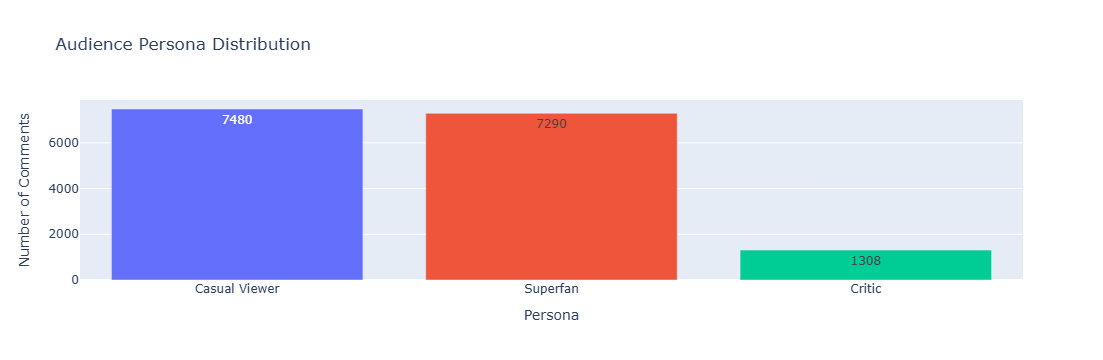

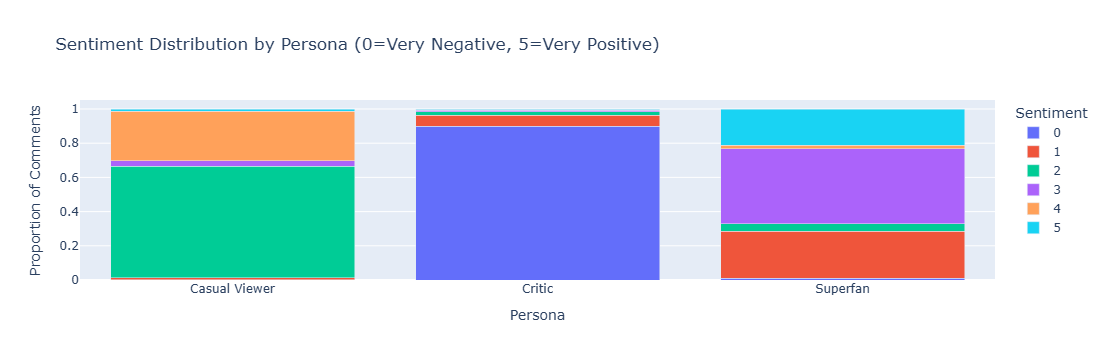

In [31]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import torch
import plotly.express as px
from tqdm import tqdm

# Load the saved tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("./deberta_sentiment_model")
model = AutoModelForSequenceClassification.from_pretrained("./deberta_sentiment_model", output_hidden_states=True)
model.eval().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load the actual dataset
try:
    df = pd.read_csv("cleaned_youtube_reviews.csv")
    df = df[['Cleaned_Review', 'Sentiment']].dropna()
    df['Sentiment'] = df['Sentiment'].astype(int)
except FileNotFoundError:
    print("Error: 'cleaned_youtube_reviews.csv' not found. Please ensure the file exists.")
    exit()

# Get real-time comment
my_comment = input("Enter your comment: ").strip()
if not my_comment:
    print("Error: No comment provided. Please enter a valid comment.")
    exit()

texts = df['Cleaned_Review'].tolist() + [my_comment]

# Predict sentiment (only for your comment)
def predict_sentiment(text, tokenizer, model):
    encodings = tokenizer(text, truncation=True, padding=True, max_length=256, return_tensors="pt")
    encodings = {key: val.to(model.device) for key, val in encodings.items()}
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        predicted_class = torch.argmax(logits, dim=1).cpu().item()
    print(f"Probabilities for '{text}': {probs}")
    return predicted_class

my_sentiment = predict_sentiment(my_comment, tokenizer, model)

# Get embeddings
def get_deberta_embeddings(texts, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating DeBERTa Embeddings"):
        batch_texts = texts[i:i + batch_size]
        encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=256, return_tensors="pt")
        encodings = {key: val.to(model.device) for key, val in encodings.items()}
        with torch.no_grad():
            outputs = model(**encodings)
            cls_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
            embeddings.extend(cls_embeddings)
    return np.array(embeddings)

embeddings = get_deberta_embeddings(texts)

# Standardize embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Combine embeddings with sentiment (stronger weight)
sentiments = np.array(df['Sentiment'].tolist() + [my_sentiment]).reshape(-1, 1)
combined_features = np.hstack((scaled_embeddings, sentiments * 5.0))  # Increase weight to 5.0

# Cluster with combined features
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
persona_labels = kmeans.fit_predict(combined_features)

# Assign initial cluster labels
df['Cluster'] = persona_labels[:-1]
my_cluster_label = persona_labels[-1]

# Calculate cluster sentiments
cluster_sentiments = df.groupby('Cluster')['Sentiment'].mean()
print("\nAverage Sentiment per Cluster (from dataset):")
for cluster, avg_sentiment in cluster_sentiments.items():
    print(f"Cluster {cluster}: {avg_sentiment:.2f}")

# Sort clusters by average sentiment and assign personas
cluster_order = cluster_sentiments.sort_values().index
persona_map = {
    cluster_order[0]: "Critic",        # Lowest sentiment
    cluster_order[1]: "Casual Viewer", # Middle sentiment
    cluster_order[2]: "Superfan"       # Highest sentiment
}
df['Persona'] = df['Cluster'].map(persona_map)

# Post-process: Reassign my comment to closest sentiment cluster
cluster_avg_list = cluster_sentiments.values
my_persona = persona_map[np.argmin(np.abs(cluster_avg_list - my_sentiment))]

# Combine data with corrected sentiments
df_with_my_comment = pd.concat([df, pd.DataFrame({
    'Cleaned_Review': [my_comment],
    'Sentiment': [my_sentiment],
    'Persona': [my_persona],
    'Cluster': [my_cluster_label]  # Keep original cluster for reference
})], ignore_index=True)

# Print results
print(f"\nProcessing complete.")
print(f"My Comment: '{my_comment}'")
print(f"Predicted Sentiment: {my_sentiment} (0=Very Negative, 5=Very Positive)")
print(f"Assigned Persona: {my_persona} (Initial Cluster: {my_cluster_label})")

# Inspect clusters
for persona in persona_map.values():
    cluster_reviews = df_with_my_comment[df_with_my_comment['Persona'] == persona][['Cleaned_Review', 'Sentiment']].head(3).values
    print(f"\nSample {persona} Reviews (Sentiment):")
    for review, sentiment in cluster_reviews:
        print(f" - '{review}' ({sentiment})")

# Persona distribution graph
persona_counts = df_with_my_comment['Persona'].value_counts().reset_index()
persona_counts.columns = ['Persona', 'Count']
fig_persona = px.bar(persona_counts, x='Persona', y='Count', title="Audience Persona Distribution",
                     color='Persona', text=persona_counts['Count'].apply(lambda x: f'{x}'), height=500)
fig_persona.update_traces(textposition='auto')
fig_persona.update_layout(showlegend=False, xaxis_title="Persona", yaxis_title="Number of Comments")
fig_persona.show()

# Sentiment distribution graph
persona_sentiment = df_with_my_comment.groupby('Persona')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)
persona_sentiment = persona_sentiment.reset_index()
fig_sentiment = px.bar(persona_sentiment.melt(id_vars=['Persona'], value_vars=[0, 1, 2, 3, 4, 5],
                                              var_name='Sentiment', value_name='Proportion'),
                       x='Persona', y='Proportion', color='Sentiment', barmode='stack',
                       title="Sentiment Distribution by Persona (0=Very Negative, 5=Very Positive)", height=500)
fig_sentiment.update_layout(xaxis_title="Persona", yaxis_title="Proportion of Comments")
fig_sentiment.show()